In [1]:
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#plt.use_style("eightthirtyfive")

In [2]:
# Loading the data into a dataframe

df = pd.read_stata("TEDS-A-2013-DS0001-bndl-data-stata_v2/tedsa_puf_2013_Stata.dta",
                  convert_categoricals=False)

In [3]:
# check the size of the data
df.shape

(1760960, 62)

In [4]:
# From the documentation -9.0 is used to represent null value 
# and since PSYPROB is our target value, we want to select all records where
# PSYPROB is not null
df = df[df['PSYPROB']!=-9]

In [5]:
df.shape

(1305760, 62)

### This happens to be more than the computatinal capacity of this PC

In [6]:
# so a random sample 0f 400K is selected
df = df.sample(400000)

In [7]:
# check the size of the new data
df.shape

(400000, 62)

In [8]:
# From the documentation on the dataset, ADMYR is admission year whichis a constant and will
# not add any statistical significant importance to our model so it will be dropped
# CASEID is unique to all records and will not contribute to the performance of our model
# so it will be droped too

df.drop(columns=['ADMYR','CASEID'], axis=1, inplace=True)

In [9]:
# From documentation, -9 is used to code missing values, it will be represented as such

for cols in df.columns:
    
    df[cols] = df[cols].apply(lambda x: np.nan if x==-9 else x)

In [10]:
# Check to see count of missing values
df.isnull().sum()

STFIPS                      0
CBSA2010               119320
EDUC                    12072
MARSTAT                 53602
SERVICES                    0
DETCRIM                294165
NOPRIOR                  8351
PSOURCE                  5021
ARRESTS                  6623
EMPLOY                   3832
METHUSE                  8684
PSYPROB                     0
PREG                   266780
GENDER                     85
VET                      9705
LIVARAG                  4821
DAYWAIT                146852
DSMCRIT                212593
AGE                         0
RACE                     3357
ETHNIC                   4157
DETNLF                 276900
PRIMINC                140951
SUB1                      783
SUB2                    13629
SUB3                    62305
ROUTE1                   5510
ROUTE2                 184428
ROUTE3                 318467
FREQ1                    6543
FREQ2                  184329
FREQ3                  317842
FRSTUSE1                 6349
FRSTUSE2  

In [11]:
# Define the X-input and y-output

X= df.drop(columns=['PSYPROB'], axis=1)
y = df.PSYPROB

In [12]:
#The `PSYPROB` is coded as 2 for those without illness while 1 represent those with illness
# so mapping is done accordingly
y = y.map({2:0, 1:1})

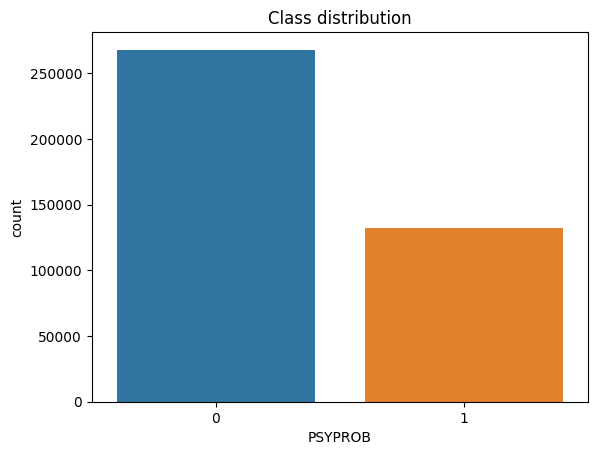

In [13]:
# Checking to see the class distribution

#y.value_counts().plot(kind='barh');
sns.countplot(x=y)
plt.title("Class distribution");

In [14]:
# Spliting the data intotraining and testing set

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

## Create a pipeline with imputer, scaler and classifier

In [15]:
pipe = make_pipeline(SimpleImputer(), StandardScaler(), 
                         RandomForestClassifier(random_state=12))
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=12))])

## Evaluate the performance

In [16]:
y_pred = pipe.predict(X_test)

print("The accuracy score is: ", accuracy_score(y_test, y_pred))
print("The precision score is: ", precision_score(y_test, y_pred))
print("The recall score is: ", recall_score(y_test, y_pred))
print("The f1 score is: ", f1_score(y_test, y_pred))


The accuracy score is:  0.7648
The precision score is:  0.6856049158859676
The recall score is:  0.5198197510119912
The f1 score is:  0.5913119026933101


# XGB

## Create a pipeline with imputer, scaler and classifier

In [17]:
pipex = make_pipeline(SimpleImputer(),
                      StandardScaler(), xgb.XGBClassifier())
pipex.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Evaluate the performance

In [22]:
y_predx = pipex.predict(X_test)

print("The accuracy score is: ", accuracy_score(y_test, y_predx))
print("The precision score is: ", precision_score(y_test, y_predx))
print("The recall score is: ", recall_score(y_test, y_predx))
print("The f1 score is: ", f1_score(y_test, y_predx))


The accuracy score is:  0.7692875
The precision score is:  0.6860705859694738
The recall score is:  0.5441457267242038
The f1 score is:  0.6069215206048344


# Model tunning with optuna library

In [19]:
def objective(trial):
    #n_estimators = trial.suggest_int("n_estimator", 100,500)
    n_estimators = trial.suggest_int("n_estimators", 100,400)
    max_depth = trial.suggest_int("max_depth",3,7)
    learning_rate = trial.suggest_float("learning_rate", .001,.1)
    
    pipex = make_pipeline(SimpleImputer(),StandardScaler(),
                          xgb.XGBClassifier(n_estimators=n_estimators, 
                                           max_depth=max_depth,
                                            learning_rate = learning_rate))
    pipex.fit(X_train,y_train)
    y_predx = pipex.predict(X_test)

    return accuracy_score(y_test, y_predx)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2023-06-29 07:22:07,196] A new study created in memory with name: no-name-6eac0874-0a13-4cbc-836f-dc9541ad681b
[I 2023-06-29 07:25:55,761] Trial 0 finished with value: 0.7617875 and parameters: {'n_estimators': 358, 'max_depth': 7, 'learning_rate': 0.026046660881614656}. Best is trial 0 with value: 0.7617875.
[I 2023-06-29 07:26:34,657] Trial 1 finished with value: 0.7380625 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.05582502192771617}. Best is trial 0 with value: 0.7617875.
[I 2023-06-29 07:29:45,290] Trial 2 finished with value: 0.766 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.045461001437038254}. Best is trial 2 with value: 0.766.
[I 2023-06-29 07:31:22,699] Trial 3 finished with value: 0.7419375 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.029761560197055583}. Best is trial 2 with value: 0.766.
[I 2023-06-29 07:34:41,764] Trial 4 finished with value: 0.7538625 and parameters: {'n_estimators':

[I 2023-06-29 10:04:38,210] Trial 39 finished with value: 0.7567875 and parameters: {'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.0594322959700815}. Best is trial 34 with value: 0.7746375.
[I 2023-06-29 10:06:39,722] Trial 40 finished with value: 0.767075 and parameters: {'n_estimators': 335, 'max_depth': 5, 'learning_rate': 0.09487811859061045}. Best is trial 34 with value: 0.7746375.
[I 2023-06-29 10:10:05,857] Trial 41 finished with value: 0.77415 and parameters: {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.08985874031048052}. Best is trial 34 with value: 0.7746375.
[I 2023-06-29 10:13:35,069] Trial 42 finished with value: 0.774575 and parameters: {'n_estimators': 385, 'max_depth': 7, 'learning_rate': 0.08603869367565367}. Best is trial 34 with value: 0.7746375.
[I 2023-06-29 10:17:05,672] Trial 43 finished with value: 0.774125 and parameters: {'n_estimators': 390, 'max_depth': 7, 'learning_rate': 0.08847710558511744}. Best is trial 34 with value: 0.7746375.
[

AttributeError: 'Study' object has no attribute 'best_values'

In [21]:
print(study.best_value)
print(study.best_params)

0.7746375
{'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.09191903847373238}


### Train a pipeline with the best parameters

In [25]:
new_pipe = make_pipeline(SimpleImputer(),
                      StandardScaler(), xgb.XGBClassifier(
                          n_estimators= 362, 
                          max_depth= 7, 
                          learning_rate= 0.09191903847373238
                      ))
new_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.09191903847373238, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=362, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

## Evaluate the performance of the new pipeline

In [26]:
y_pred_new = new_pipe.predict(X_test)

print("The accuracy score is: ", accuracy_score(y_test, y_pred_new))
print("The precision score is: ", precision_score(y_test, y_pred_new))
print("The recall score is: ", recall_score(y_test, y_pred_new))
print("The f1 score is: ", f1_score(y_test, y_pred_new))

The accuracy score is:  0.7746375
The precision score is:  0.695208921648399
The recall score is:  0.554685709921332
The f1 score is:  0.6170479406954268


In [27]:
pd.crosstab(y_test, y_pred_new)

col_0,0,1
PSYPROB,,
0,47446,6368
1,11661,14525
